In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')
from pycaret.regression import *
from sklearn.metrics import mean_squared_error, r2_score
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# fe = fm.FontEntry(
#     fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # ttf 파일이 저장되어 있는 경로
#     name='NanumBarunGothic')  # 이 폰트의 원하는 이름 설정
# fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})  # 폰트 설정
# plt.rc('font', family='NanumBarunGothic')
fe = fm.FontEntry(
    fname=r'/System/Library/Fonts/Supplemental/AppleGothic.ttf',  # ttf 파일이 저장되어 있는 경로
    name='AppleGothic')  # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'AppleGothic'})  # 폰트 설정
plt.rc('font', family='AppleGothic')

In [2]:
train = pd.read_csv('../03_outlier/train_processed.csv')
test = pd.read_csv('../03_outlier/test_processed.csv')

In [3]:
target_col = 'target_log_clip'

In [4]:
# PyCaret 환경 설정
# K-Fold(5겹) + 셔플
reg_setup = setup(
    data=train,
    target=target_col,
    fold=5,
    fold_strategy='kfold',
    fold_shuffle=True,
    session_id=123
)

# 모델 비교 (⭐ 오래 걸리는 모델 제외)
# exclude 리스트에 제외하고 싶은 모델의 ID를 문자열로 추가합니다.
# 일반적으로 'svm', 'kr', 'knn'이 오래 걸리는 경향이 있습니다.
best_model = compare_models(exclude=['svm', 'kr', 'knn'], sort='RMSE',n_select = 4)

,Description,Value
0,Session id,123
1,Target,target_log_clip
2,Target type,Regression
3,Original data shape,"(96698, 69)"
4,Transformed data shape,"(96698, 119)"
5,Transformed train set shape,"(67688, 119)"
6,Transformed test set shape,"(29010, 119)"
7,Ordinal features,1
8,Numeric features,46
9,Categorical features,21


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0505,0.0101,0.1004,0.9672,0.0085,0.0046,7.7460
rf,Random Forest Regressor,0.0539,0.0118,0.1086,0.9615,0.0091,0.0049,11.7660
lightgbm,Light Gradient Boosting Machine,0.0738,0.0126,0.1123,0.9589,0.0094,0.0068,1.1320
dt,Decision Tree Regressor,0.0664,0.0161,0.1266,0.9477,0.0106,0.0061,0.5620
gbr,Gradient Boosting Regressor,0.0978,0.0178,0.1333,0.9421,0.0112,0.0090,5.3780
lr,Linear Regression,0.1274,0.0296,0.1721,0.9035,0.0147,0.0118,0.6660
ridge,Ridge Regression,0.1277,0.0297,0.1724,0.9032,0.0147,0.0118,0.3040
br,Bayesian Ridge,0.1277,0.0297,0.1724,0.9031,0.0147,0.0118,0.4280
ada,AdaBoost Regressor,0.1395,0.0330,0.1816,0.8925,0.0153,0.0128,3.0020
en,Elastic Net,0.2462,0.0968,0.3111,0.6847,0.0260,0.0225,0.8720


In [5]:
best_model

[ExtraTreesRegressor(n_jobs=-1, random_state=123),
 RandomForestRegressor(n_jobs=-1, random_state=123),
 LGBMRegressor(n_jobs=-1, random_state=123),
 DecisionTreeRegressor(random_state=123)]

In [6]:
X = train.drop(columns=target_col)
y = train[target_col].astype(float)
X_test = test.drop(columns=['is_test']) if 'is_test' in test.columns else test.copy()

In [7]:
# ===== 유틸 함수들 =====
def prepare_predictions(y_pred, prevent_negative: bool = True, round_int: bool = False):
    import numpy as np
    y_pred = np.asarray(y_pred, dtype=float)
    if prevent_negative:
        y_pred = np.maximum(0, y_pred)
    if round_int:
        y_pred = np.rint(y_pred).astype(np.int64)
    return y_pred

def regression_metrics(y_true, y_pred):
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

def build_compare_df(y_true, y_pred):
    import pandas as pd
    compare_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    compare_df['residual'] = compare_df['y_true'] - compare_df['y_pred']
    return compare_df

def plot_diagnostics(compare_df, sample_size=5000, random_state=2023):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    # 샘플링
    sample = compare_df.sample(min(sample_size, len(compare_df)), random_state=random_state)
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # 1) 예측 vs 실제
    sns.scatterplot(x='y_true', y='y_pred', data=sample, s=10, alpha=0.5, ax=axes[0])
    lim_min = min(sample['y_true'].min(), sample['y_pred'].min())
    lim_max = max(sample['y_true'].max(), sample['y_pred'].max())
    axes[0].plot([lim_min, lim_max], [lim_min, lim_max], color='red', linestyle='--', linewidth=1)
    axes[0].set_title('예측 vs 실제 (원스케일)')
    axes[0].set_xlabel('실제값')
    axes[0].set_ylabel('예측값')

    # 2) 잔차 vs 예측
    sns.scatterplot(x='y_pred', y='residual', data=sample, s=10, alpha=0.5, ax=axes[1])
    axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[1].set_title('잔차 vs 예측')
    axes[1].set_xlabel('예측값')
    axes[1].set_ylabel('잔차(실제-예측)')

    # 3) 잔차 분포
    sns.histplot(compare_df['residual'], bins=50, kde=True, ax=axes[2], color='steelblue')
    axes[2].axvline(0, color='red', linestyle='--', linewidth=1)
    axes[2].set_title('잔차 분포')

    plt.tight_layout()
    return fig, axes

In [8]:
# ===== 지표/가중치 계산 유틸 =====
def _safe_rmsle(y_true_, y_pred_):
    import numpy as np
    y_true_clip = np.clip(y_true_, 0, None)
    y_pred_clip = np.clip(y_pred_, 0, None)
    return float(np.sqrt(np.mean((np.log1p(y_true_clip) - np.log1p(y_pred_clip))**2)))

def _safe_mape(y_true_, y_pred_, eps=1e-9):
    import numpy as np
    denom = np.where(np.abs(y_true_) < eps, eps, np.abs(y_true_))
    return float(np.mean(np.abs((y_true_ - y_pred_) / denom)) * 100.0)

def compute_weights_from_metrics(metrics_df, strategy="inv_rmse", power=1.0, temperature=0.2, combine=None):
    import numpy as np
    df = metrics_df.copy()
    eps = 1e-12
    s = strategy.lower()

    def _normalize(w):
        w = np.asarray(w, dtype=float)
        if not np.isfinite(w).all() or np.allclose(w.sum(), 0.0):
            raise ValueError("가중치 벡터가 유효하지 않습니다.")
        return w / w.sum()

    if s == "inv_rmse":
        if "RMSE" not in df: raise ValueError("metrics_df에 RMSE가 필요합니다.")
        w = 1.0 / (df["RMSE"].to_numpy() + eps)
        w = np.power(w, power)
        return _normalize(w)

    if s == "softmax_rmse":
        if "RMSE" not in df: raise ValueError("metrics_df에 RMSE가 필요합니다.")
        x = -df["RMSE"].to_numpy() / max(temperature, eps)
        x = x - np.max(x)
        e = np.exp(x)
        return _normalize(e)

    if s == "r2_clip":
        if "R2" not in df: raise ValueError("metrics_df에 R2가 필요합니다.")
        w = np.maximum(df["R2"].to_numpy(), 0.0)
        w = np.power(w, power)
        return _normalize(w)

    if s == "composite":
        # 낮을수록 좋은 지표: RMSE, MAE, MAPE, RMSLE, MSE -> 역수
        # 높을수록 좋은 지표: R2 -> 그대로(+클립)
        if not combine:
            combine = {"RMSE": 0.6, "MAPE": 0.25, "R2": 0.15}
        score = np.zeros(len(df), dtype=float)
        for k, alpha in combine.items():
            if k not in df: continue
            v = df[k].to_numpy(dtype=float)
            if k.upper() in ("RMSE", "MAE", "MAPE", "RMSLE", "MSE"):
                comp = 1.0 / (v + eps)
            elif k.upper() == "R2":
                comp = np.maximum(v, 0.0)
            else:
                continue
            score += alpha * comp
        score = np.clip(score, eps, None)
        return _normalize(score)

    raise ValueError(f"알 수 없는 strategy: {strategy}")

In [9]:
# ===== 모델 순회 및 평가/시각화 =====
models = best_model if isinstance(best_model, list) else [best_model]

# 공통: y_true는 원스케일
y_true = np.expm1(y.values).astype(float)

pred_list_log = []  # 각 모델의 log-스케일 예측 저장(향후 평균용)

In [12]:
# ===== 모델 순회: 예측/지표 수집 =====
rows = []
for m in models:
    df_pred = predict_model(m, data=train)  # Label: 로그 스케일 예측
    if 'prediction_label' not in df_pred.columns:
        raise ValueError("model 결과에 'prediction_label' 컬럼이 없습니다.")

    y_pred_log = df_pred['prediction_label'].to_numpy()
    pred_list_log.append(y_pred_log)

    y_pred = np.expm1(y_pred_log).astype(float)

    # 지표 계산
    mae = float(np.mean(np.abs(y_true - y_pred)))
    mse = float(np.mean((y_true - y_pred) ** 2))
    rmse = float(np.sqrt(mse))
    # r2_score 재사용
    r2 = float(r2_score(y_true, y_pred))
    rmsle = _safe_rmsle(y_true, y_pred)
    mape = _safe_mape(y_true, y_pred)

    rows.append({
        "model": type(m).__name__,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "RMSLE": rmsle,
        "MAPE": mape
    })

metrics_df = pd.DataFrame(rows)
metrics_df = metrics_df.set_index("model")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0137,0.0022,0.0471,0.9928,0.0040,0.0013


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0249,0.0029,0.0534,0.9907,0.0045,0.0023


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0651,0.0079,0.0890,0.9741,0.0075,0.0060


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0180,0.0035,0.0590,0.9886,0.0050,0.0016


In [13]:
# ===== 모든 전략을 순회하여 가중치만 담은 DataFrame 만들기 =====
# 전략 세트 정의(필요 시 자유롭게 추가/수정)
strategies = {
    "inv_rmse_pow1.0": {"strategy": "inv_rmse", "power": 1.0},
    "inv_rmse_pow1.5": {"strategy": "inv_rmse", "power": 1.5},
    "softmax_rmse_T0.1": {"strategy": "softmax_rmse", "temperature": 0.1},
    "softmax_rmse_T0.2": {"strategy": "softmax_rmse", "temperature": 0.2},
    "r2_clip_pow1.0": {"strategy": "r2_clip", "power": 1.0},
    "composite_rmse0.6_mape0.3_r20.1": {"strategy": "composite", "combine": {"RMSE": 0.6, "MAPE": 0.3, "R2": 0.1}},
}

# weights_df: 각 컬럼이 전략, 각 값은 해당 전략으로 계산된 모델 가중치
weights_df = pd.DataFrame(index=metrics_df.index)

for name, cfg in strategies.items():
    w = compute_weights_from_metrics(
        metrics_df,
        strategy=cfg.get("strategy", "inv_rmse"),
        power=cfg.get("power", 1.0),
        temperature=cfg.get("temperature", 0.2),
        combine=cfg.get("combine", None),
    )
    # 각 전략별 가중치 컬럼 추가(가중치 합=1)
    weights_df[name] = w

# 전략별 가중치 합이 1인지 확인(디버그용)
# print(weights_df.sum(axis=0))

display(weights_df.sort_index())


,inv_rmse_pow1.0,inv_rmse_pow1.5,softmax_rmse_T0.1,softmax_rmse_T0.2,r2_clip_pow1.0,composite_rmse0.6_mape0.3_r20.1
model,,,,,,
DecisionTreeRegressor,0.249590,0.243514,0.0,0.0,0.250788,0.280252
ExtraTreesRegressor,0.325027,0.361879,1.0,1.0,0.251964,0.333699
LGBMRegressor,0.152711,0.116544,0.0,0.0,0.245995,0.152983
RandomForestRegressor,0.272672,0.278063,0.0,0.0,0.251253,0.233066


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0137,0.0022,0.0471,0.9928,0.0040,0.0013


[1/4] ExtraTreesRegressor | RMSE(orig)=3,632.7414  MAE(orig)=902.3121  R²=0.9933


,y_true,y_pred,residual
0,124000.0,123999.950501,0.049499
1,123500.0,123500.026343,-0.026343
2,91500.0,106334.379145,-14834.379145
3,130000.0,129999.966616,0.033384
4,117000.0,117000.038226,-0.038226
5,130000.0,129999.966616,0.033384
6,139500.0,139500.007531,-0.007531
7,107500.0,107500.020859,-0.020859
8,145000.0,137056.387312,7943.612688
9,112000.0,111999.953630,0.046370


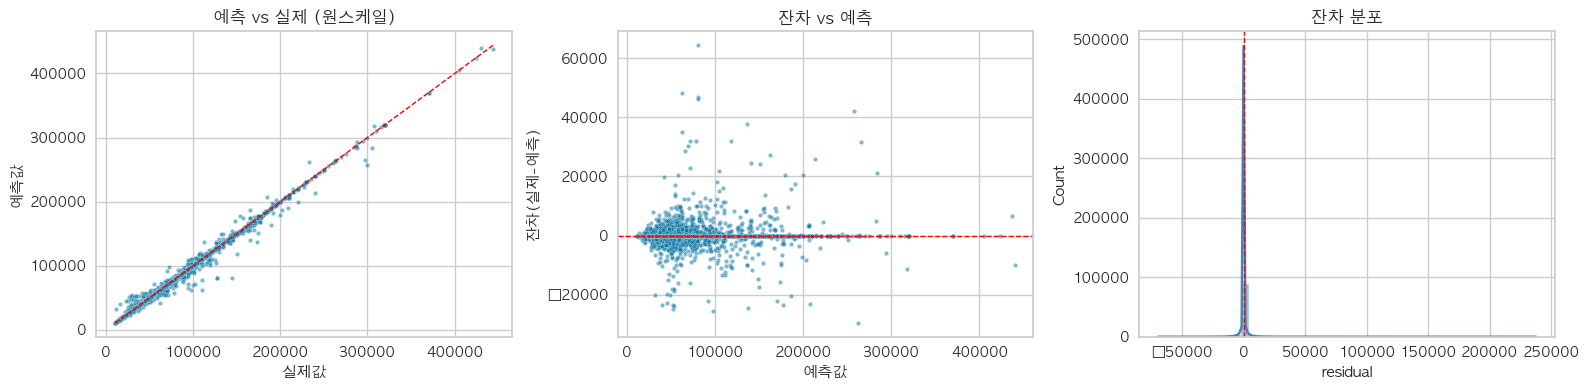

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0249,0.0029,0.0534,0.9907,0.0045,0.0023


[2/4] RandomForestRegressor | RMSE(orig)=4,330.2582  MAE(orig)=1,678.7921  R²=0.9905


,y_true,y_pred,residual
0,124000.0,123321.687098,678.312902
1,123500.0,123386.029315,113.970685
2,91500.0,100970.038424,-9470.038424
3,130000.0,126810.166137,3189.833863
4,117000.0,122561.473454,-5561.473454
5,130000.0,127941.580579,2058.419421
6,139500.0,134844.120467,4655.879533
7,107500.0,111489.613292,-3989.613292
8,145000.0,141061.066610,3938.933390
9,112000.0,111769.573240,230.426760


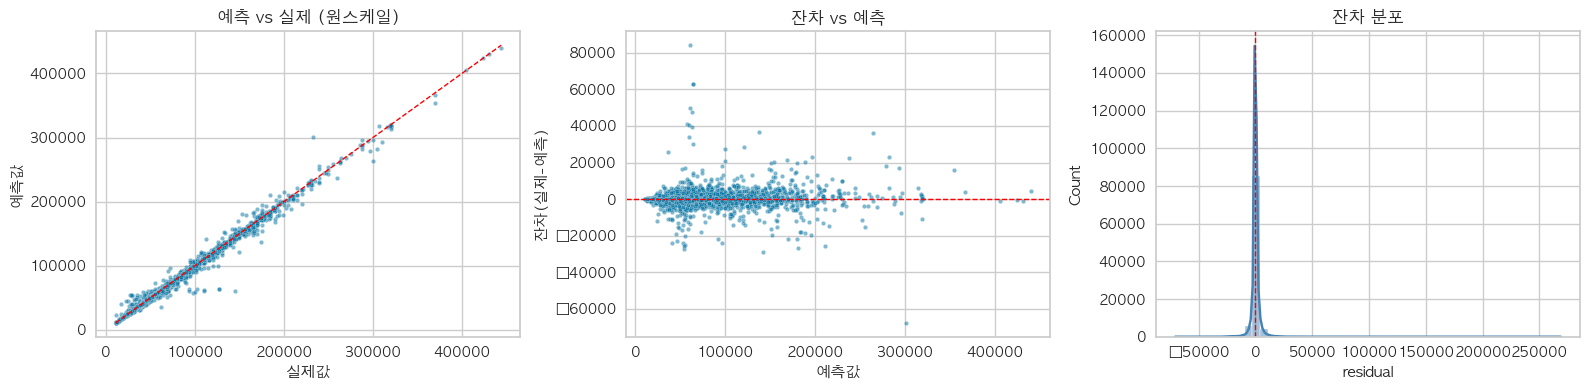

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0651,0.0079,0.0890,0.9741,0.0075,0.0060


[3/4] LGBMRegressor | RMSE(orig)=7,731.8553  MAE(orig)=4,405.9856  R²=0.9698


,y_true,y_pred,residual
0,124000.0,117289.219559,6710.780441
1,123500.0,117031.790186,6468.209814
2,91500.0,97585.128886,-6085.128886
3,130000.0,123874.590195,6125.409805
4,117000.0,124313.534669,-7313.534669
5,130000.0,122216.687412,7783.312588
6,139500.0,125591.889933,13908.110067
7,107500.0,109795.115785,-2295.115785
8,145000.0,128878.099382,16121.900618
9,112000.0,113235.640168,-1235.640168


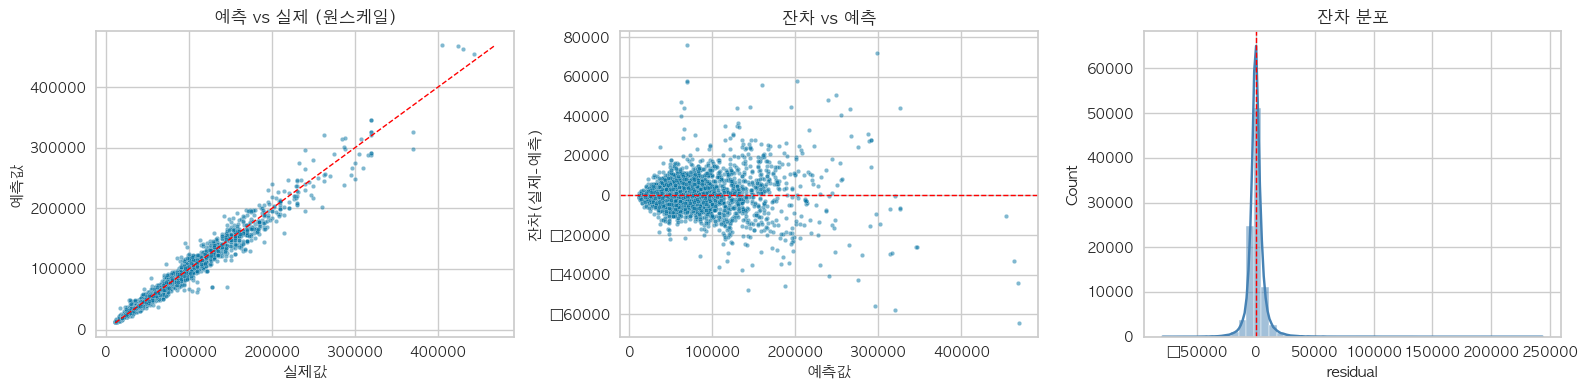

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0180,0.0035,0.0590,0.9886,0.0050,0.0016


[4/4] DecisionTreeRegressor | RMSE(orig)=4,730.7171  MAE(orig)=1,201.0890  R²=0.9887


,y_true,y_pred,residual
0,124000.0,123999.950501,0.049499
1,123500.0,123500.026343,-0.026343
2,91500.0,80999.979797,10500.020203
3,130000.0,129999.966616,0.033384
4,117000.0,117000.038226,-0.038226
5,130000.0,129999.966616,0.033384
6,139500.0,139500.007531,-0.007531
7,107500.0,107500.020859,-0.020859
8,145000.0,159999.937213,-14999.937213
9,112000.0,111999.953630,0.046370


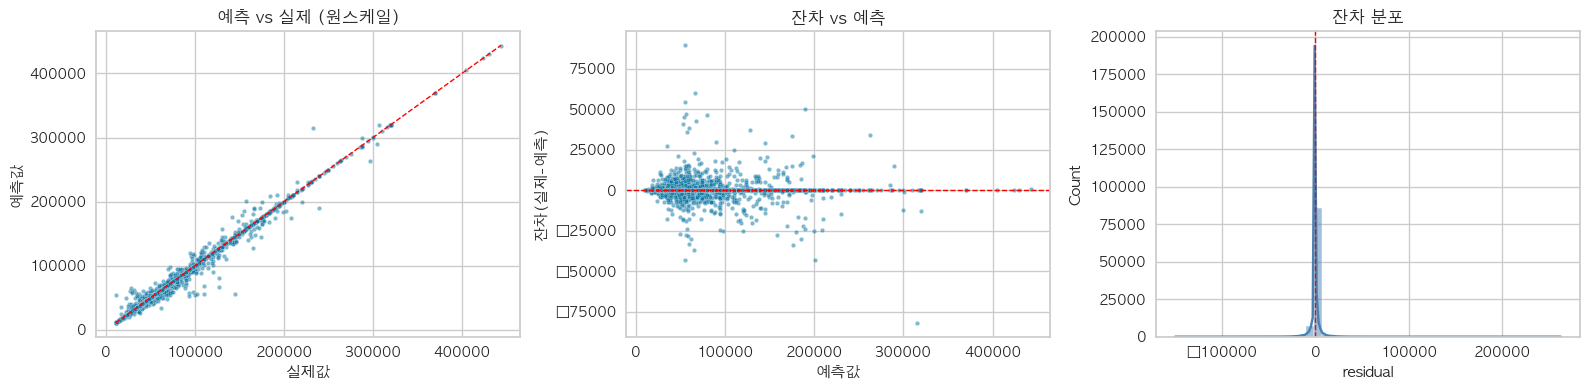

In [14]:
for idx, m in enumerate(models, start=1):
    df_pred = predict_model(m, data=train)  # 'Label' 컬럼: log 스케일 예측
    if 'prediction_label' not in df_pred.columns:
        raise ValueError("결과에 'prediction_label' 컬럼이 없습니다.")

    y_pred_log = df_pred['prediction_label'].to_numpy()
    pred_list_log.append(y_pred_log)

    # 원스케일 변환
    y_pred = np.expm1(y_pred_log)

    # 안전장치(음수 방지), 반올림 옵션
    y_pred = prepare_predictions(y_pred, prevent_negative=True, round_int=False)

    # 지표 계산
    rmse, mae, r2 = regression_metrics(y_true, y_pred)
    print(f"[{idx}/{len(models)}] {m.__class__.__name__} | RMSE(orig)={rmse:,.4f}  MAE(orig)={mae:,.4f}  R²={r2:,.4f}")

    # 비교/잔차 프레임
    compare_df = build_compare_df(y_true, y_pred)
    display(compare_df.head(10))

    # 시각화(샘플 5,000개까지)
    fig, axes = plot_diagnostics(compare_df, sample_size=5000, random_state=2023)
    plt.show()

[Ensemble mean of models] RMSE(orig)=4,301.3250  MAE(orig)=1,866.4699  R²=0.9907


,y_true,y_pred,residual
0,124000.0,122119.535962,1880.464038
1,123500.0,121822.072947,1677.927053
2,91500.0,95980.656806,-4480.656806
3,130000.0,127645.555199,2354.444801
4,117000.0,120174.161427,-3174.161427
5,130000.0,127499.116831,2500.883169
6,139500.0,134736.580525,4763.419475
7,107500.0,109058.277057,-1558.277057
8,145000.0,141302.990747,3697.009253
9,112000.0,112249.807419,-249.807419


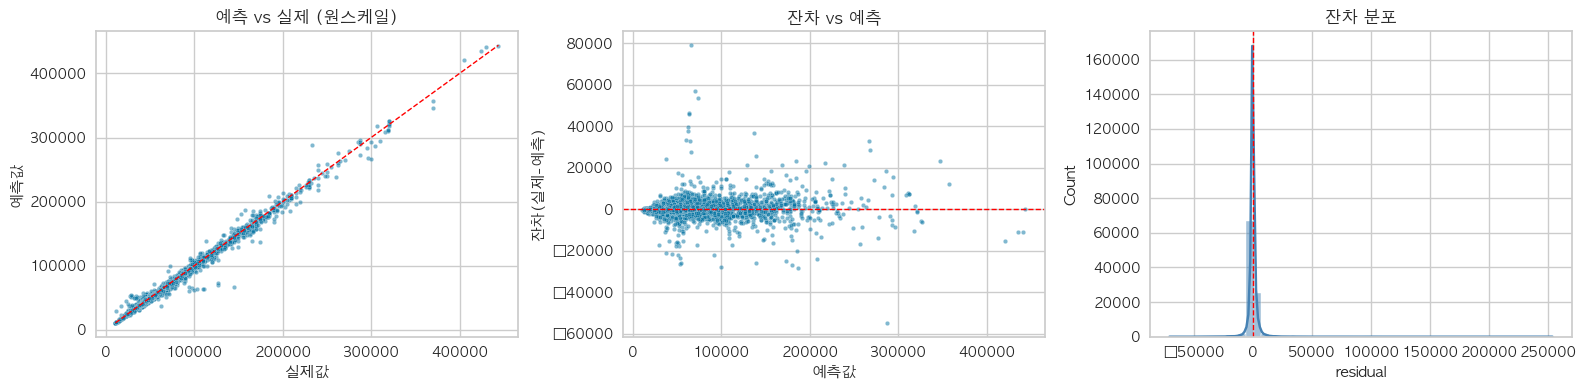

[Weighted ensemble: inv_rmse_pow1.0] weights=[0.325  0.2727 0.1527 0.2496] | RMSE(orig)=4,047.1341  MAE(orig)=1,562.5039  R²=0.9917


,y_true,y_pred,residual
0,124000.0,122767.093292,1232.906708
1,123500.0,122458.764671,1041.235329
2,91500.0,96683.063056,-5183.063056
3,130000.0,128174.124945,1825.875055
4,117000.0,119593.201543,-2593.201543
5,130000.0,128220.837358,1779.162642
6,139500.0,136015.653812,3484.346188
7,107500.0,108924.320391,-1424.320391
8,145000.0,142235.153009,2764.846991
9,112000.0,112124.809818,-124.809818


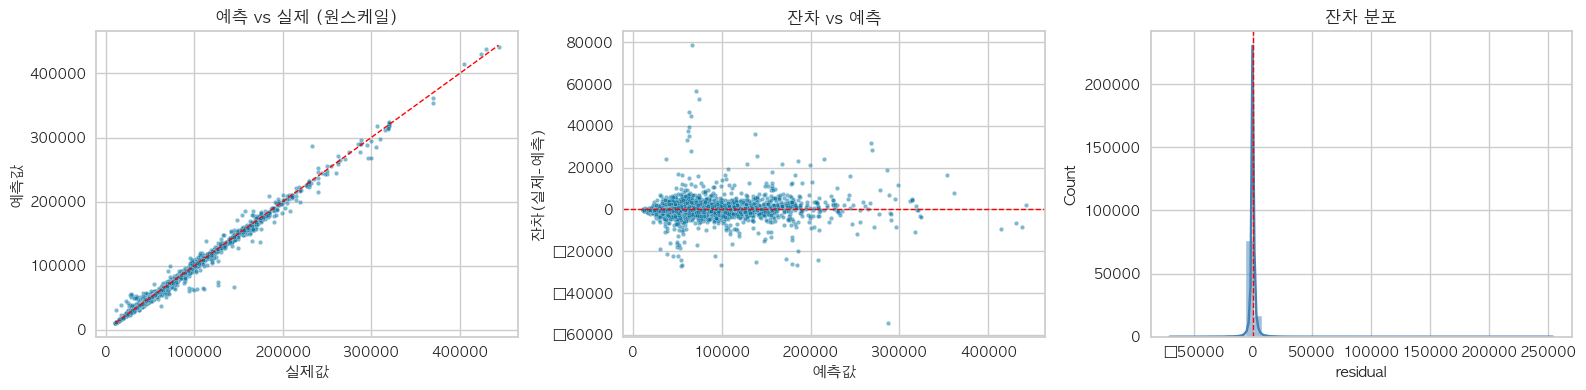

[Weighted ensemble: inv_rmse_pow1.5] weights=[0.3619 0.2781 0.1165 0.2435] | RMSE(orig)=3,969.4772  MAE(orig)=1,451.0333  R²=0.9920


,y_true,y_pred,residual
0,124000.0,123010.746618,989.253382
1,123500.0,122696.646934,803.353066
2,91500.0,97117.158277,-5617.158277
3,130000.0,128380.863420,1619.136580
4,117000.0,119361.112822,-2361.112822
5,130000.0,128496.405585,1503.594415
6,139500.0,136508.310765,2991.689235
7,107500.0,108862.516775,-1362.516775
8,145000.0,142440.127983,2559.872017
9,112000.0,112079.078157,-79.078157


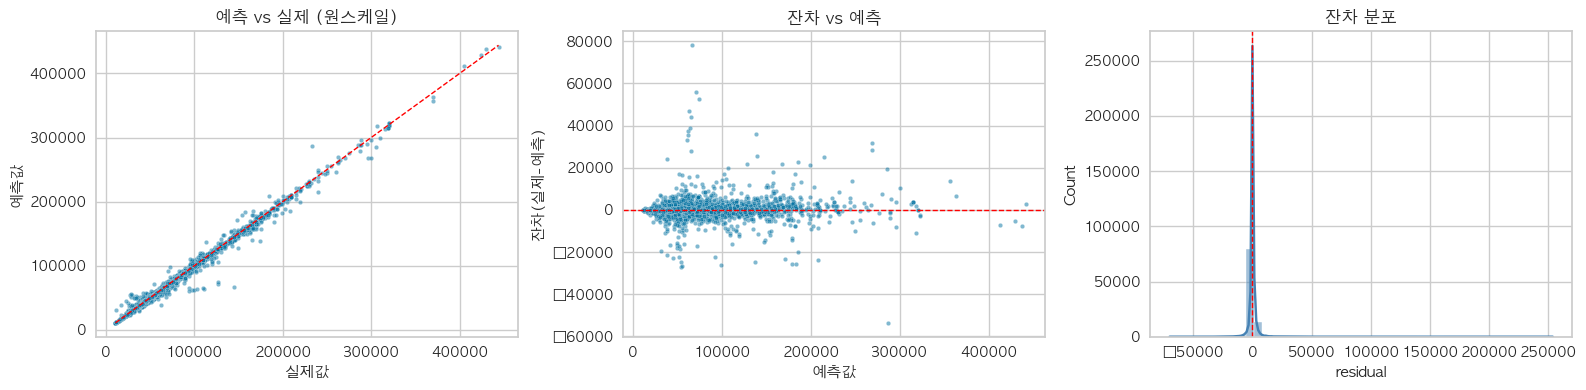

[Weighted ensemble: softmax_rmse_T0.1] weights=[1. 0. 0. 0.] | RMSE(orig)=3,632.7414  MAE(orig)=902.3121  R²=0.9933


,y_true,y_pred,residual
0,124000.0,123999.950501,0.049499
1,123500.0,123500.026343,-0.026343
2,91500.0,106334.379145,-14834.379145
3,130000.0,129999.966616,0.033384
4,117000.0,117000.038226,-0.038226
5,130000.0,129999.966616,0.033384
6,139500.0,139500.007531,-0.007531
7,107500.0,107500.020859,-0.020859
8,145000.0,137056.387312,7943.612688
9,112000.0,111999.953630,0.046370


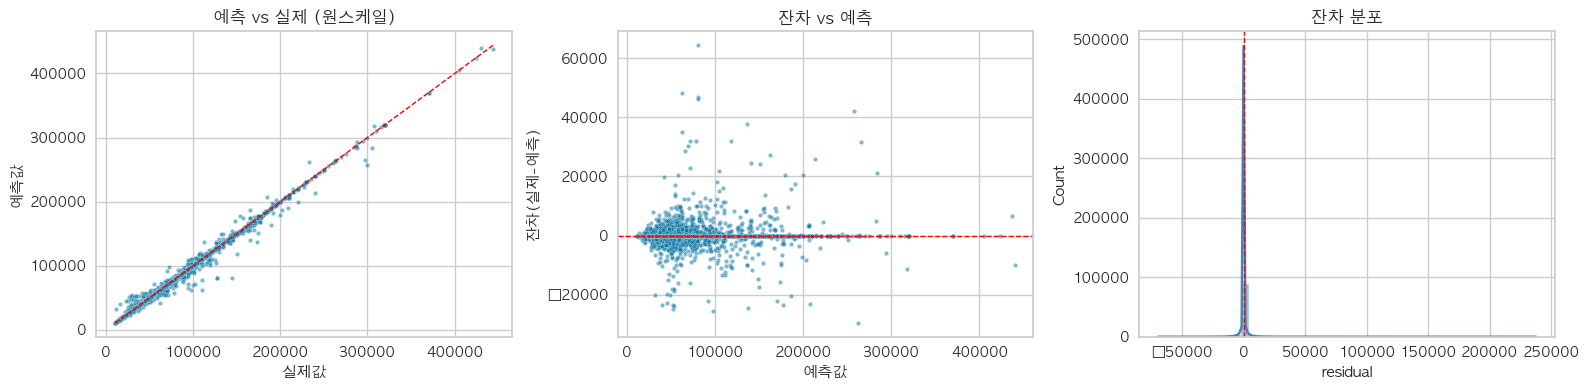

[Weighted ensemble: softmax_rmse_T0.2] weights=[1. 0. 0. 0.] | RMSE(orig)=3,632.7414  MAE(orig)=902.3121  R²=0.9933


,y_true,y_pred,residual
0,124000.0,123999.950501,0.049499
1,123500.0,123500.026343,-0.026343
2,91500.0,106334.379145,-14834.379145
3,130000.0,129999.966616,0.033384
4,117000.0,117000.038226,-0.038226
5,130000.0,129999.966616,0.033384
6,139500.0,139500.007531,-0.007531
7,107500.0,107500.020859,-0.020859
8,145000.0,137056.387312,7943.612688
9,112000.0,111999.953630,0.046370


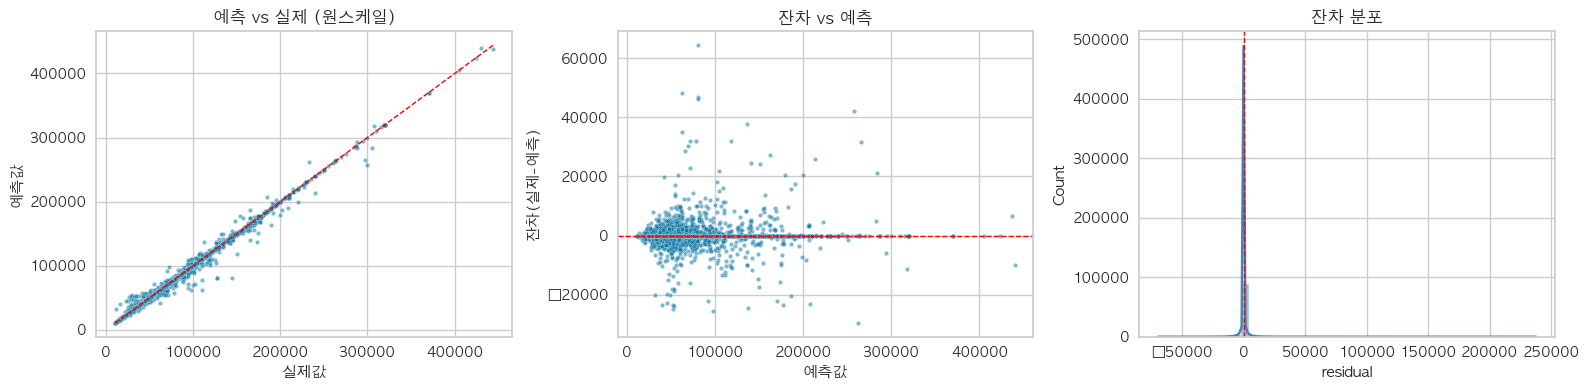

[Weighted ensemble: r2_clip_pow1.0] weights=[0.252  0.2513 0.246  0.2508] | RMSE(orig)=4,290.0634  MAE(orig)=1,854.0583  R²=0.9907


,y_true,y_pred,residual
0,124000.0,122145.911283,1854.088717
1,123500.0,121848.181125,1651.818875
2,91500.0,95986.862222,-4486.862222
3,130000.0,127666.257723,2333.742277
4,117000.0,120151.972748,-3151.972748
5,130000.0,127528.096141,2471.903859
6,139500.0,134787.534223,4712.465777
7,107500.0,109054.028830,-1554.028830
8,145000.0,141360.147095,3639.852905
9,112000.0,112244.585287,-244.585287


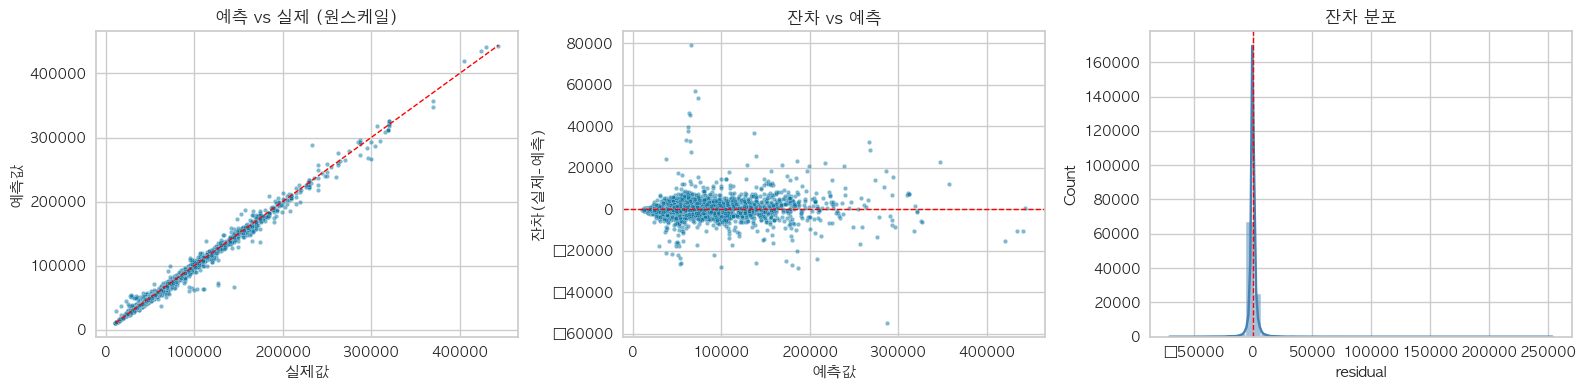

[Weighted ensemble: composite_rmse0.6_mape0.3_r20.1] weights=[0.3337 0.2331 0.153  0.2803] | RMSE(orig)=4,037.8024  MAE(orig)=1,543.4760  R²=0.9918


,y_true,y_pred,residual
0,124000.0,122791.907564,1208.092436
1,123500.0,122461.452505,1038.547495
2,91500.0,96074.195755,-4574.195755
3,130000.0,128298.616319,1701.383681
4,117000.0,119375.413553,-2375.413553
5,130000.0,128299.760441,1700.239559
6,139500.0,136194.749409,3305.250591
7,107500.0,108767.854574,-1267.854574
8,145000.0,142746.478814,2253.521186
9,112000.0,112134.288623,-134.288623


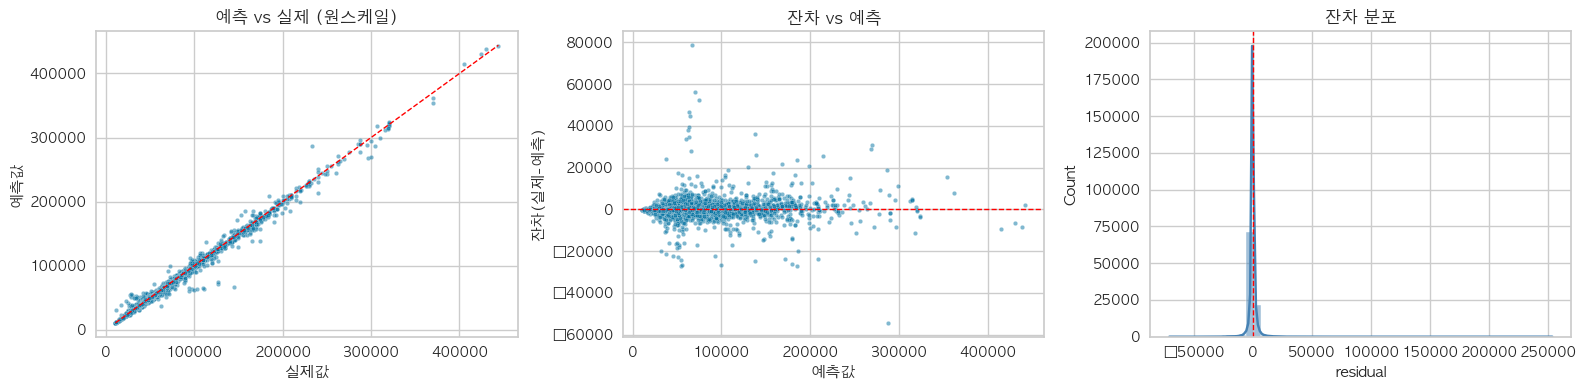

In [24]:
# ===== 여러 모델이면 행평균(Ensemble mean)도 평가 =====
if len(models) > 1:
    M = np.column_stack(pred_list_log)  # shape: (n_samples, n_models)
    preds_train_log = np.mean(M, axis=1)
    y_pred = np.expm1(preds_train_log)
    y_pred = prepare_predictions(y_pred, prevent_negative=True, round_int=False)

    rmse, mae, r2 = regression_metrics(y_true, y_pred)
    print(f"[Ensemble mean of models] RMSE(orig)={rmse:,.4f}  MAE(orig)={mae:,.4f}  R²={r2:,.4f}")

    compare_df = build_compare_df(y_true, y_pred)
    display(compare_df.head(10))

    fig, axes = plot_diagnostics(compare_df, sample_size=5000, random_state=2023)
    plt.show()

    # ----- 가중치 전략별 앙상블 평가 -----
    # 1) 현재 models 리스트의 컬럼 순서에 맞게 가중치를 정렬
    model_names = [type(m).__name__ for m in models]

    # 2) 각 전략 컬럼을 순회하며 aligned weight 벡터 구성
    for strat in weights_df.columns:
        try:
            # 가중치가 존재하는 모델만 선택(교집합)
            valid_idx = [i for i, nm in enumerate(model_names) if nm in weights_df.index]
            if len(valid_idx) == 0:
                print(f"[Skip] '{strat}': weights_df에 해당 모델 인덱스가 없습니다.")
                continue
            if len(valid_idx) < len(model_names):
                missing = [nm for nm in model_names if nm not in weights_df.index]
                print(f"[Warn] '{strat}': weights_df에 없는 모델이 있어 제외합니다 -> {missing}")

            # M과 가중치 모두 동일한 순서/길이로 정렬
            M_use = np.column_stack([pred_list_log[i] for i in valid_idx])
            ordered_names = [model_names[i] for i in valid_idx]
            w = weights_df.loc[ordered_names, strat].to_numpy(dtype=float)

            # 유효성 검사 + 정규화
            if not np.isfinite(w).all():
                raise ValueError("가중치에 유한하지 않은 값이 포함되어 있습니다.")
            if np.allclose(w.sum(), 0.0):
                raise ValueError("가중치 합이 0입니다.")
            if not np.isclose(w.sum(), 1.0):
                w = w / w.sum()

        except Exception as e:
            print(f"[Skip] '{strat}': 가중치 사용 중 오류 발생 -> {e}")
            continue

        preds_train_log_w = np.average(M_use, axis=1, weights=w)
        y_pred_w = np.expm1(preds_train_log_w)
        y_pred_w = prepare_predictions(y_pred_w, prevent_negative=True, round_int=False)

        rmse, mae, r2 = regression_metrics(y_true, y_pred_w)
        print(f"[Weighted ensemble: {strat}] weights={np.round(w, 4)} | RMSE(orig)={rmse:,.4f}  MAE(orig)={mae:,.4f}  R²={r2:,.4f}")

        compare_df_w = build_compare_df(y_true, y_pred_w)
        display(compare_df_w.head(10))

        fig, axes = plot_diagnostics(compare_df_w, sample_size=5000, random_state=2023)
        plt.show()
